# Détection du cancer du sein par Anthony RENARD 🦊 - 08 Octobre 2023

https://www.linkedin.com/in/anthonyrenardfox/

Images des radiographies disponibles sous : https://www.kaggle.com/datasets/ahmedmohamedabdallah/breastcancer/data

# 📥 1. Importation des librairies

In [1]:
import os
import cv2
import glob
import time
import warnings
import itertools
import visualkeras
import pandas as pd
import numpy  as np
from PIL import Image
import seaborn as sns
import tensorflow as tf
import geopandas as gpd
from PIL import ImageFile
from random import randint
import plotly.express as px
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from collections import Counter
from scipy.ndimage import rotate
from keras.models import load_model
from tensorflow.keras import layers
from sklearn.utils import class_weight
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')
%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

C:\Users\Utilisateur\anaconda3\envs\projet10\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Setting up general parameters

In [2]:
# General parameters
epochs = 15
pic_size = 120#240
np.random.seed(42)
tf.random.set_seed(42)

# 🗃️ 2. Chargement du Dataset

## 2.1 Méthode 1 : Sous forme de Numpy Array

In [3]:
folder_path = "./Data"
no_images = os.listdir(folder_path + '/Negative/')
yes_images = os.listdir(folder_path + '/Cancer/')
dataset=[]
lab=[]

for image_name in no_images:
    image=cv2.imread(folder_path + '/Negative/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((120,120))#240,240
    dataset.append(np.array(image))
    lab.append(0)
    
for image_name in yes_images:
    image=cv2.imread(folder_path + '/Cancer/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((120,120))#240,240
    dataset.append(np.array(image))
    lab.append(1)

In [4]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(820, 120, 120, 3) (820,)


## 2.2 Méthode 2 : Sous forme de DataFrame

In [5]:
path = './Data'
path_imgs = list(glob.glob(path+'/**/*.jpg'))

In [6]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

File_Path    Labels
0  ./Data\Negative\307.jpg  Negative
1      ./Data\Cancer\4.jpg    Cancer
2     ./Data\Cancer\16.jpg    Cancer
3  ./Data\Negative\344.jpg  Negative
4     ./Data\Cancer\89.jpg    Cancer

# 🔥 3. Analyse des données (EDA)

## 3.1 Echantillons

In [7]:
def plot_state(state):
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path + "/" + state + "/" + os.listdir(folder_path + "/" + state)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)   
    plt.show()

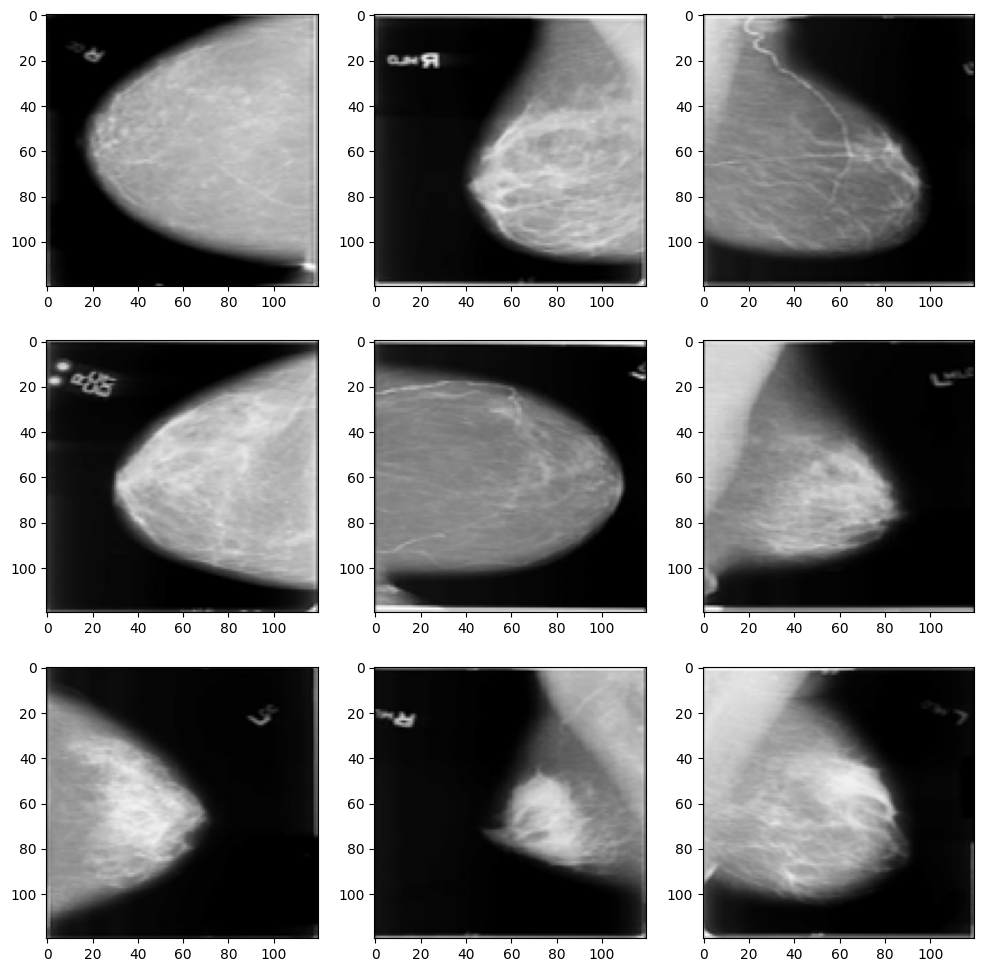

In [8]:
plot_state('Cancer')

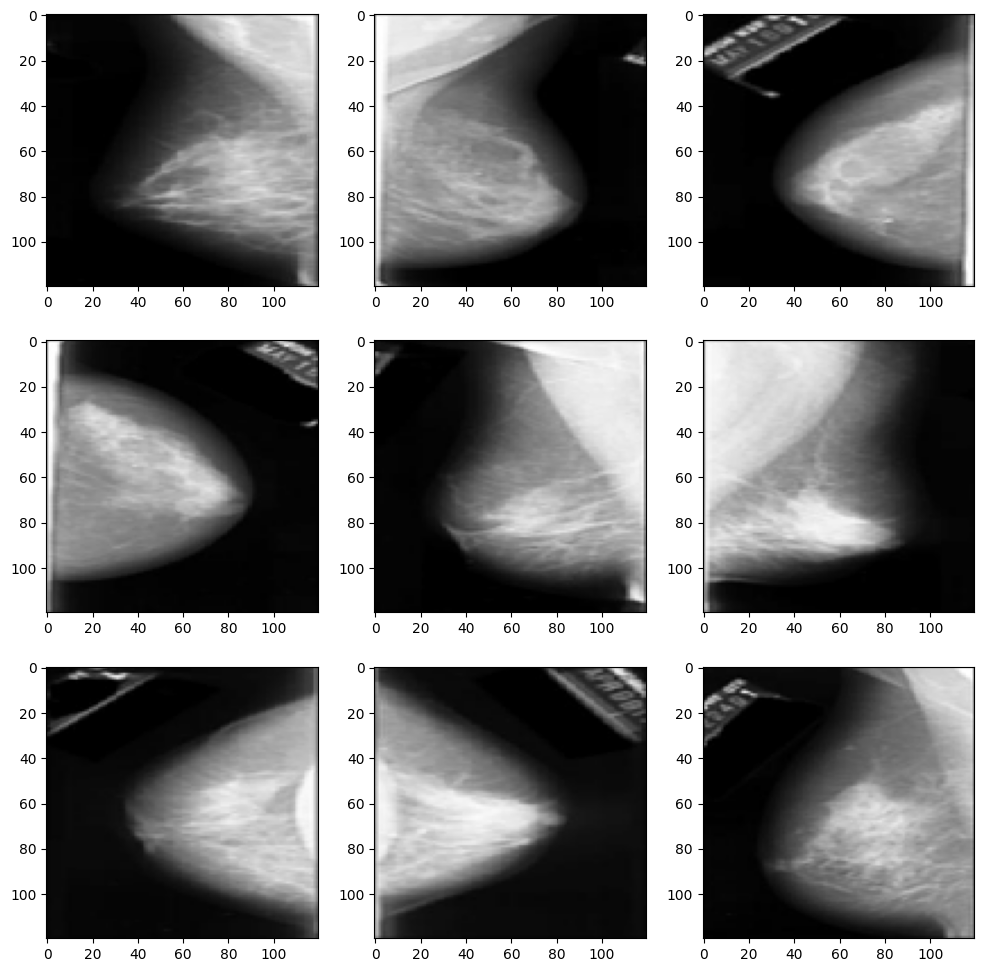

In [9]:
plot_state("Negative")

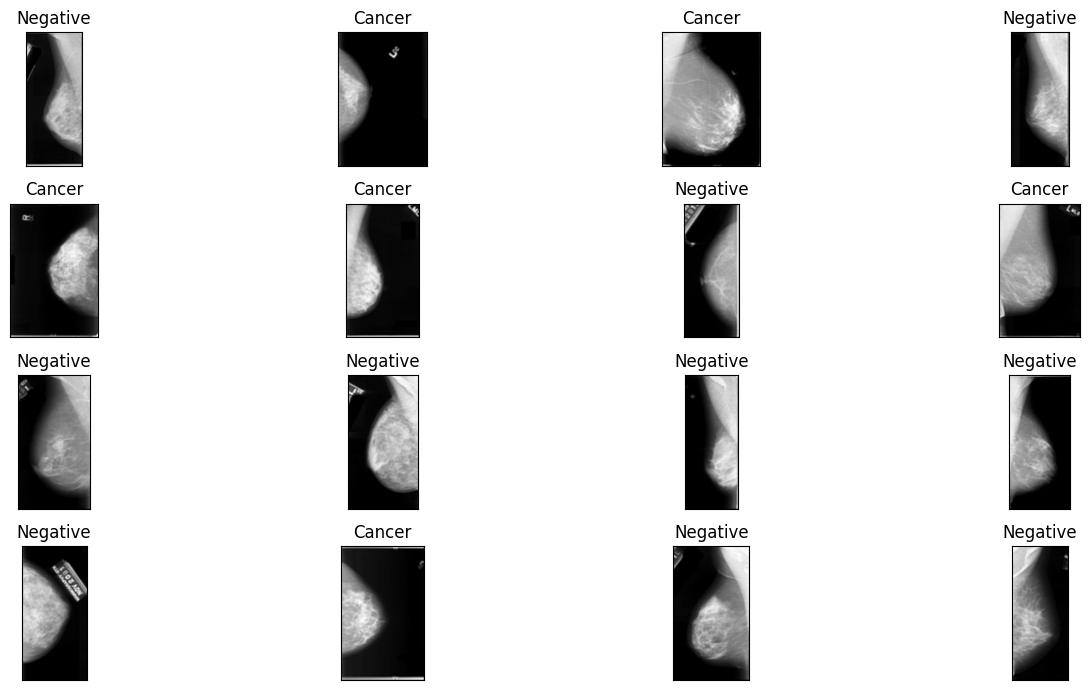

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

## 3.2 Proportions

[Text(0, 0, '410'), Text(0, 0, '410')]

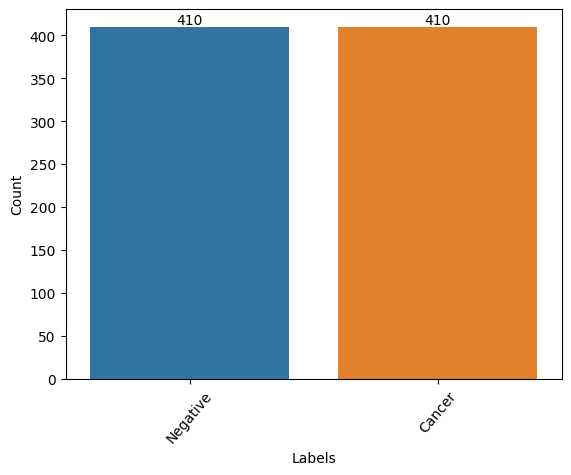

In [11]:
counts = data.Labels.value_counts(normalize=False)
ax = sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);
ax.bar_label(ax.containers[0], fmt='%.0f')

[Text(0, 0, '0.50'), Text(0, 0, '0.50')]

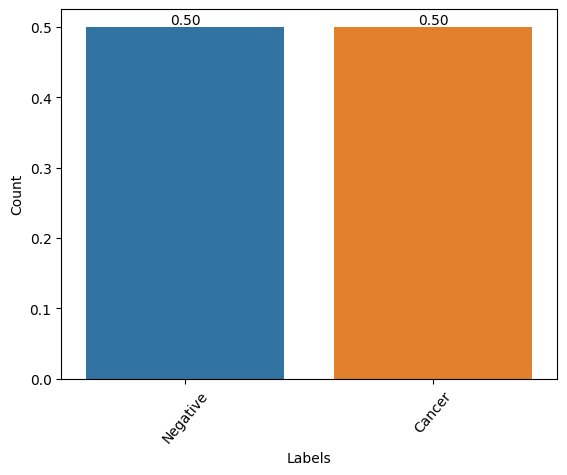

In [12]:
counts = data.Labels.value_counts(normalize=True)
ax = sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);
ax.bar_label(ax.containers[0], fmt='%.2f')

## 3.3 Quelques transformations

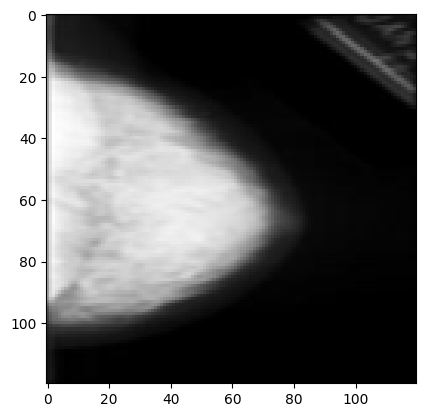

In [13]:
plt.imshow(dataset[0])

### 3.3.1 Rotation

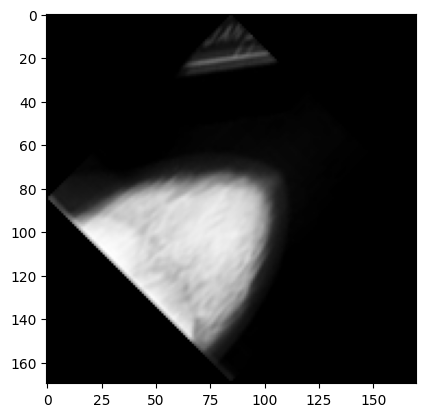

In [14]:
rotate_img = rotate(dataset[0], 45)
plt.imshow(rotate_img)

### 3.3.2 Zoom

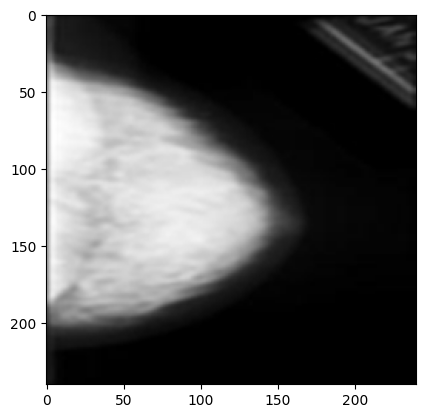

In [15]:
# Création d'un image PILLOW à partir de l'image en array
pil_image = Image.fromarray(np.uint8(dataset[0]))

#Facteur pour zoomer
zoom_factor = 2

# Calcul de la nouvelle dimension
new_width = dataset[0].shape[1] * zoom_factor
new_height = dataset[0].shape[0] * zoom_factor

# Resize avec Pilow pour garder le nombre de channel identique (3)
zoomed_pil_image = pil_image.resize((new_width, new_height), Image.ANTIALIAS)

# Convertion du zoom en array
zoomed_image = np.array(zoomed_pil_image)

plt.imshow(zoomed_image)

#Remarque : l'utilisation de scipy.ndimage.zoom ne permet pas de maintenir directement le channel RGB à 3

### 3.3.3 Filtrage Gaussien

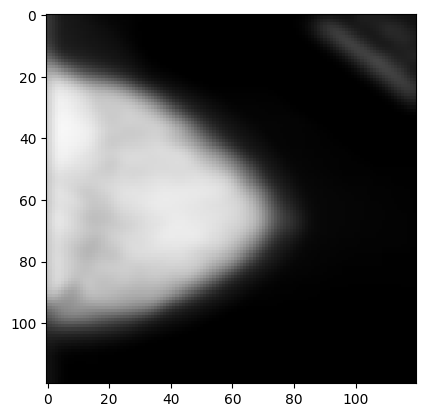

In [16]:
from scipy.ndimage import gaussian_filter
gauss_img =  gaussian_filter(dataset[0],2)
plt.imshow(gauss_img)


### 3.3.4 Shift Fourrier

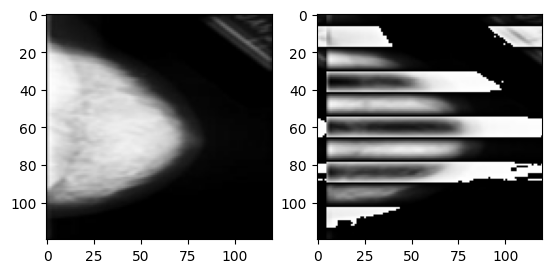

In [17]:
import numpy.fft
from scipy import ndimage
fig, (ax1, ax2) = plt.subplots(1, 2)
#plt.gray()  # show the filtered result in grayscale
input_ = numpy.fft.fft2(dataset[0])
result = ndimage.fourier_shift(input_, shift=5)
result = numpy.fft.ifft2(result)
ax1.imshow(dataset[0].astype('uint8'))
ax2.imshow(result.real.astype('uint8'))  # the imaginary part is an artifact
plt.show()

### 3.3.5 Shift

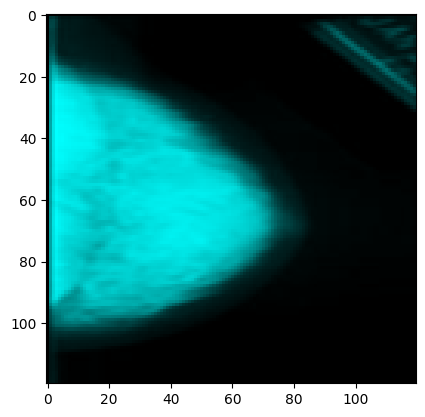

In [18]:
from scipy.ndimage import shift
shift_img =  shift(dataset[0],1)
plt.imshow(shift_img)


# ✂️ 4. Train & Test Split

In [19]:
#Split des data sous forme de np.array
x_train, x_test, y_train, y_test = train_test_split(dataset, lab,stratify=lab,  test_size=0.2, shuffle=True, random_state=42)

In [20]:
#Split des data sous forme de DateFrame
train_df, test_df = train_test_split(data, stratify=data["Labels"], test_size=0.2, shuffle=True, random_state=42)

# 📚 5. Modèles

## ✔️ 5.1 Simple CNN (configuré à la main)

### 5.1.1 Création et entrainement du modèle

In [21]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(pic_size,pic_size,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 59, 59, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 64)                1

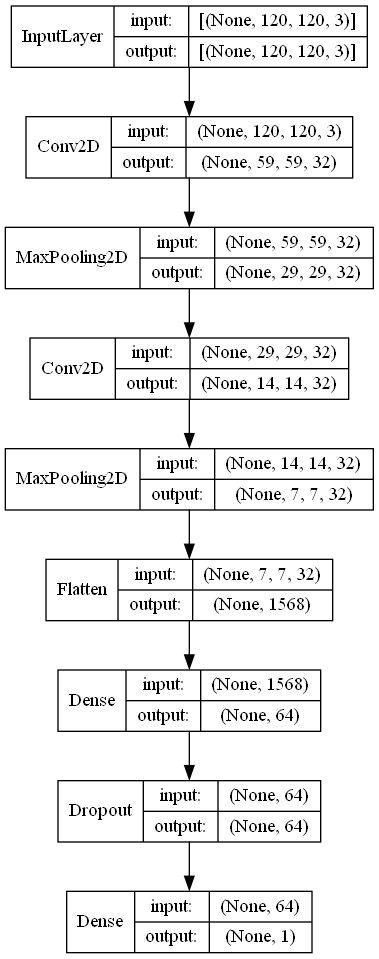

In [23]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [24]:
visualkeras.layered_view(model, legend=False).show()

In [25]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.0, 1: 1.0}

In [26]:
start = time.time()
history = model.fit(x_train,y_train,epochs = 100, class_weight=class_weights, validation_data=(x_test, y_test),verbose=1)
end = time.time()
print("Temps d'entrainement =",(format((end-start)/60)),"min")

Epoch 1/100
21/21 [==============================] - 2s 38ms/step - loss: 12.6849 - accuracy: 0.5640 - val_loss: 3.3846 - val_accuracy: 0.5732
Epoch 2/100
21/21 [==============================] - 1s 30ms/step - loss: 3.2293 - accuracy: 0.5716 - val_loss: 3.0348 - val_accuracy: 0.5915
Epoch 3/100
21/21 [==============================] - 1s 28ms/step - loss: 2.9727 - accuracy: 0.5366 - val_loss: 2.8627 - val_accuracy: 0.6037
Epoch 4/100
21/21 [==============================] - 1s 28ms/step - loss: 2.8270 - accuracy: 0.5503 - val_loss: 2.7671 - val_accuracy: 0.5793
Epoch 5/100
21/21 [==============================] - 1s 29ms/step - loss: 2.7269 - accuracy: 0.5564 - val_loss: 2.6668 - val_accuracy: 0.6220
Epoch 6/100
21/21 [==============================] - 1s 29ms/step - loss: 2.6564 - accuracy: 0.5686 - val_loss: 2.6107 - val_accuracy: 0.6463
Epoch 7/100
21/21 [==============================] - 1s 29ms/step - loss: 2.5797 - accuracy: 0.5793 - val_loss: 2.5334 - val_accuracy: 0.6829
Epoch

In [27]:
# Enregsitrement et chargement du modèle sous format .h5
 
# Enregistrement du modèle
model.save('./modeles/breast_cancer_simple_cnn.h5')
print('Model Saved!')
 
# Chargement du modèle
savedModel=load_model('./modeles/breast_cancer_simple_cnn.h5')
savedModel.summary()

Model Saved!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 59, 59, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 64)    

### 5.1.2 Evaluation

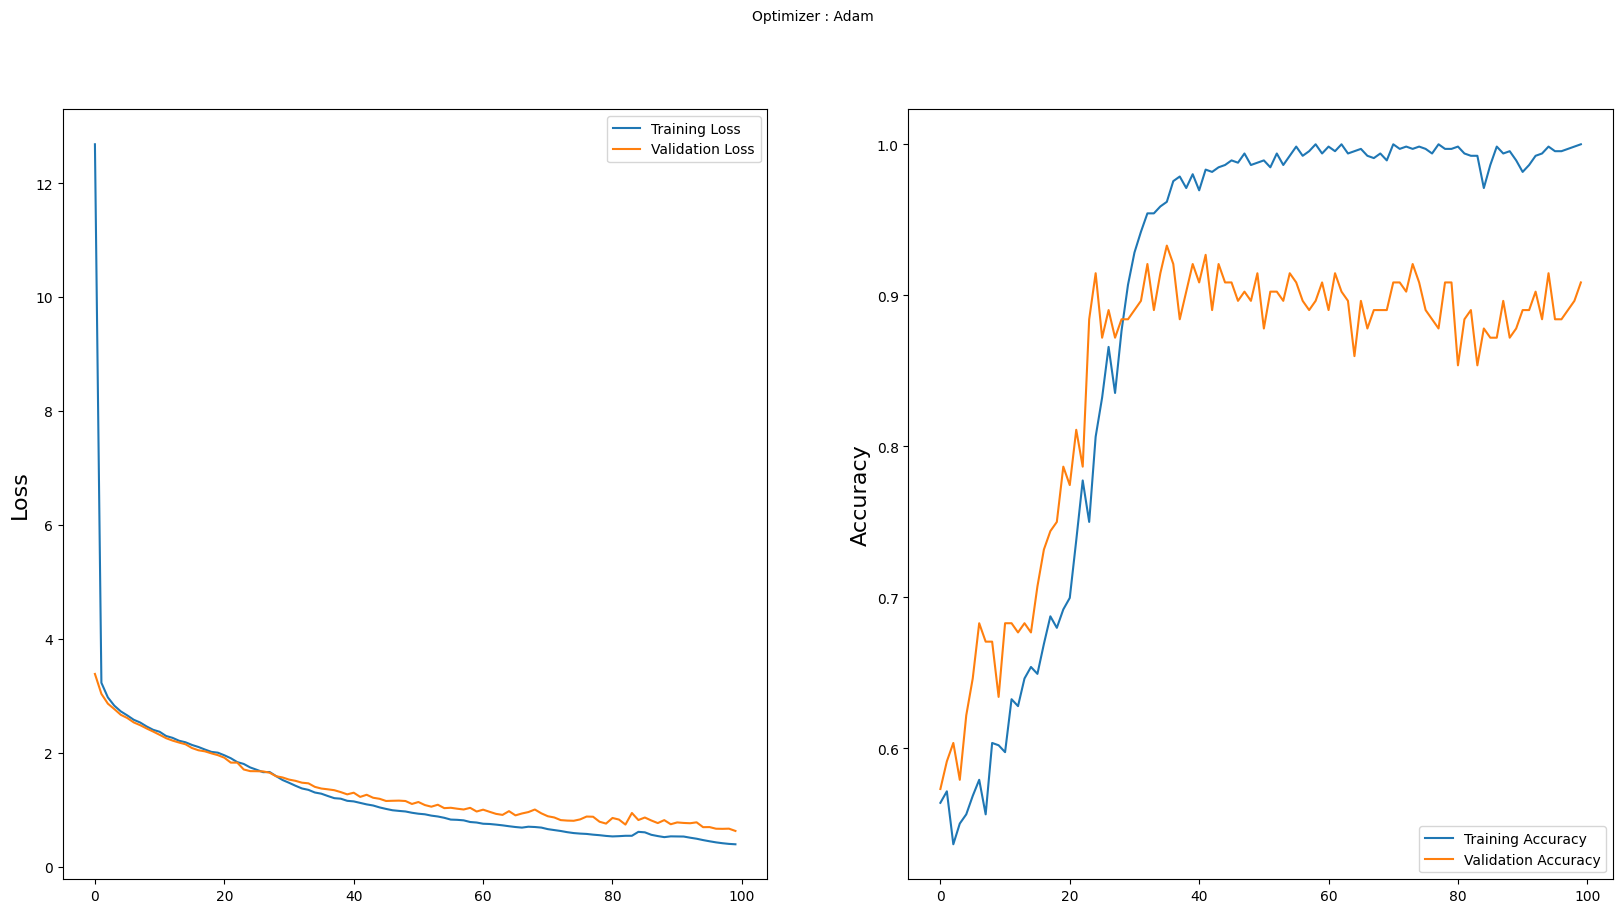

In [28]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [29]:
results = model.evaluate(x_test, y_test)
print('The current model achieved an accuracy of {}%!'.format(round(results[1]*100,2)))

6/6 [==============================] - 0s 8ms/step - loss: 0.6277 - accuracy: 0.9085
The current model achieved an accuracy of 90.85%!


In [30]:
# compute predictions
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

6/6 [==============================] - 0s 8ms/step


In [31]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

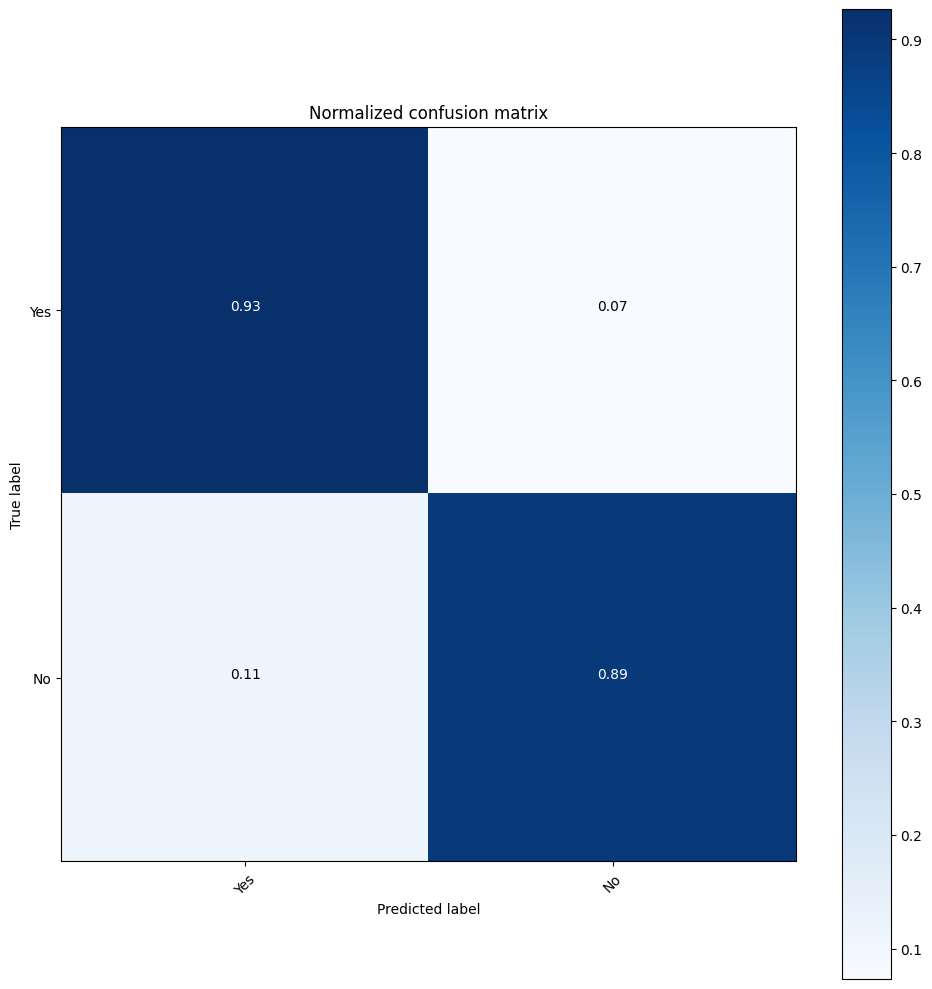

In [32]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Yes", "No"], title='Normalized confusion matrix')
plt.show()

## ✔️ 5.2 Vision Transformers (ViT)

### 5.2.1 Paramètres

In [33]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 120#240  # We'll resize input images to this size
patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

### 5.2.2 Utilisation de l'augmentation

In [34]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

### 5.2.3 Multi-layer perceptron

In [35]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### 5.2.4 Implémentation de la couche "Patch"

In [36]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 120 X 120
Patch size: 20 X 20
Patches per image: 36
Elements per patch: 1200


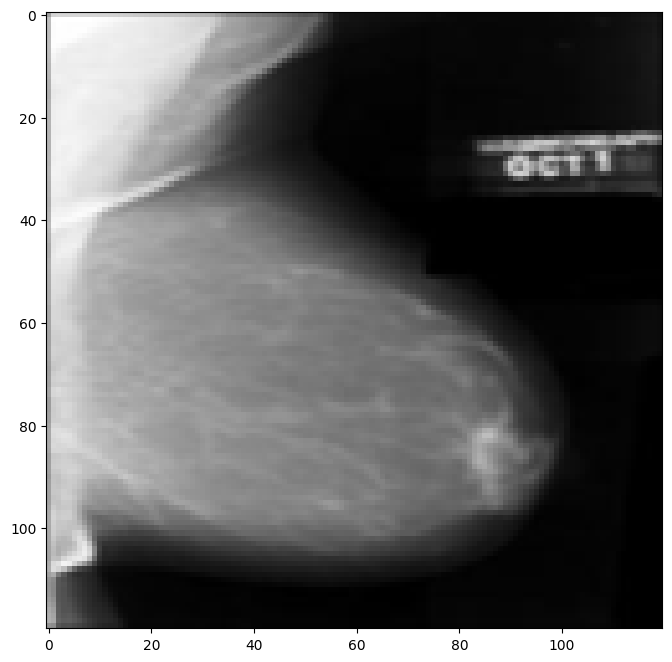

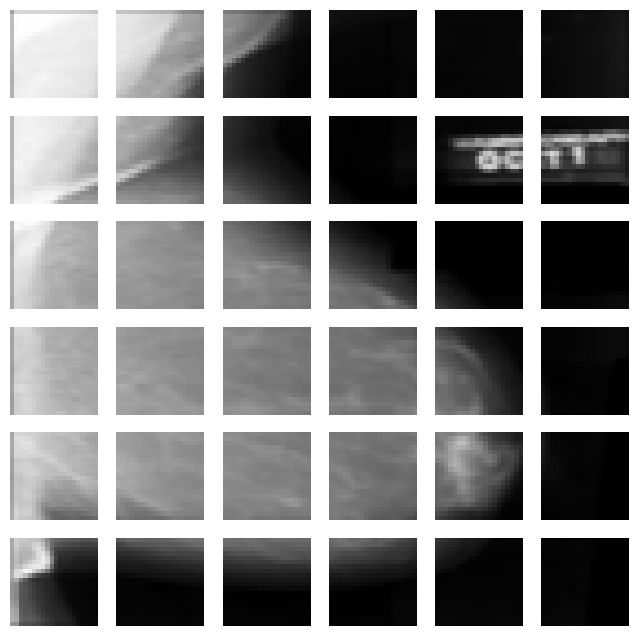

In [37]:
plt.figure(figsize=(8, 8))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


### 5.2.5 Création de l'encodeur pour le patch

In [38]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### 5.2.6 Création et entrainement du modèle

In [39]:
def create_vit_classifier():
    inputs = layers.Input(shape=(120, 120, 3))#240, 240
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model


In [40]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    start = time.time()
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )
    end = time.time()
    print("Temps d'entrainement =",(format(((end-start)/60)/60),"heures"))

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    
    model.save('./modeles/breast_cancer_vit.h5')
    print('Model ViT enregistré!')

    return history, model

In [41]:
vit_classifier = create_vit_classifier()
vit_history, model_ViT = run_experiment(vit_classifier)

Epoch 1/100
3/3 [==============================] - 18s 3s/step - loss: 4.9669 - accuracy: 0.4985 - top-5-accuracy: 1.0000 - val_loss: 0.8179 - val_accuracy: 0.6707 - val_top-5-accuracy: 1.0000
Epoch 2/100
3/3 [==============================] - 6s 2s/step - loss: 1.0760 - accuracy: 0.6159 - top-5-accuracy: 1.0000 - val_loss: 0.6744 - val_accuracy: 0.6829 - val_top-5-accuracy: 1.0000
Epoch 3/100
3/3 [==============================] - 6s 2s/step - loss: 0.8512 - accuracy: 0.6677 - top-5-accuracy: 1.0000 - val_loss: 0.7368 - val_accuracy: 0.6220 - val_top-5-accuracy: 1.0000
Epoch 4/100
3/3 [==============================] - 5s 2s/step - loss: 0.7852 - accuracy: 0.6677 - top-5-accuracy: 1.0000 - val_loss: 0.4542 - val_accuracy: 0.7500 - val_top-5-accuracy: 1.0000
Epoch 5/100
3/3 [==============================] - 5s 2s/step - loss: 0.6948 - accuracy: 0.7043 - top-5-accuracy: 1.0000 - val_loss: 0.4752 - val_accuracy: 0.6951 - val_top-5-accuracy: 1.0000
Epoch 6/100
3/3 [======================

In [42]:
# Test load model
savedModel=load_model('./modeles/breast_cancer_vit.h5', custom_objects={'Patches': Patches,'PatchEncoder': PatchEncoder})
savedModel.summary()
# Problème de nom couche à résoudre

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 120, 120, 3)          7         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_2 (Patches)         (None, None, 1200)           0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 36, 64)               79168     ['patches_2[0][0]']       

### 5.2.7 Evaluation

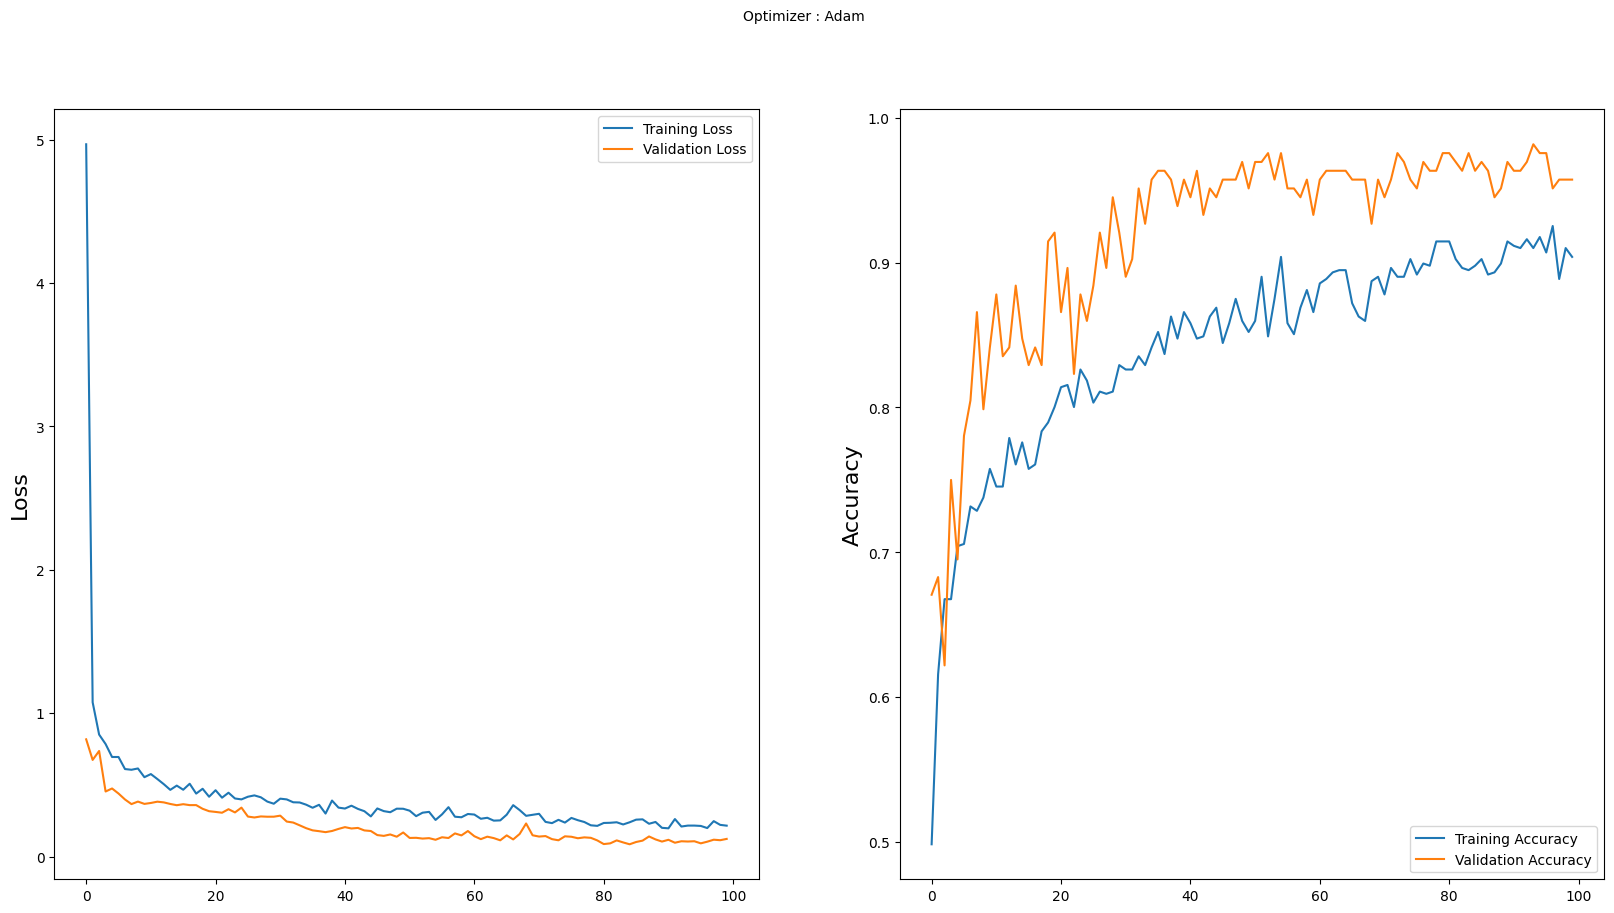

In [43]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(vit_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [44]:
# compute predictions
vit_predictions = vit_classifier.predict(x_test)
vit_y_pred = [np.argmax(probas) for probas in vit_predictions]

6/6 [==============================] - 2s 73ms/step


<Figure size 640x480 with 0 Axes>

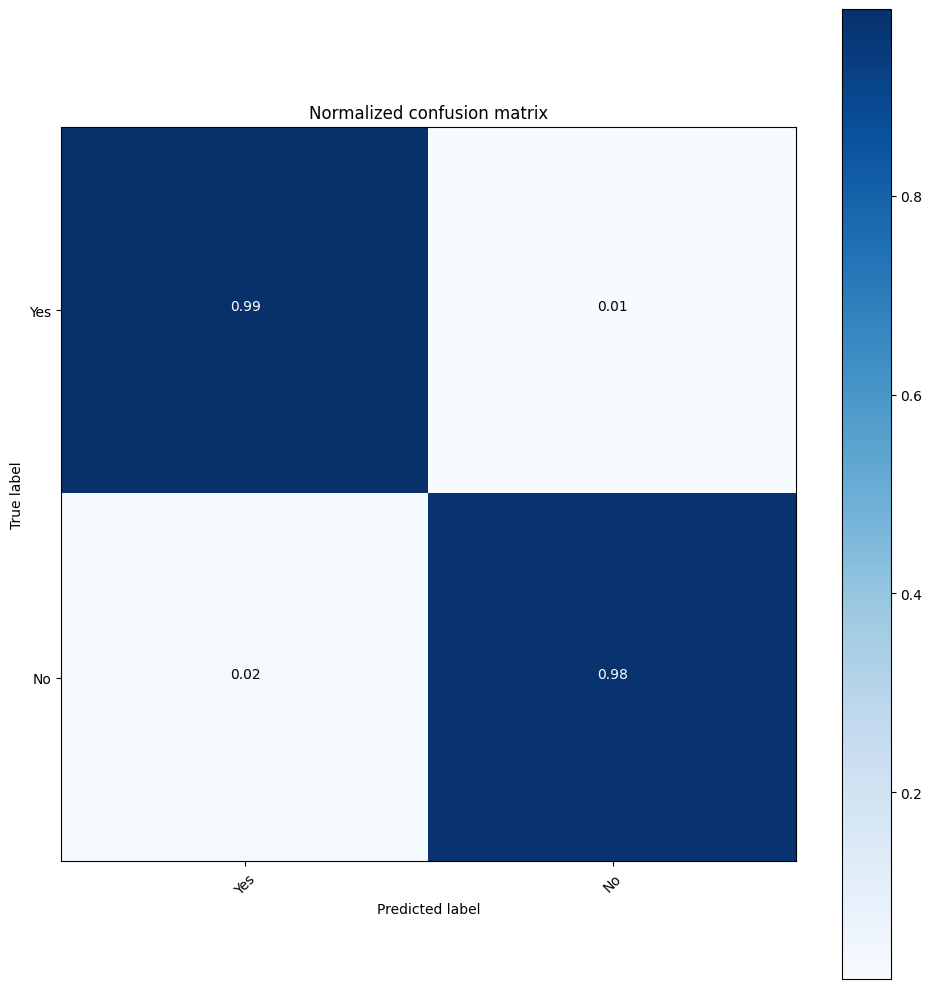

In [45]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, vit_y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Yes", "No"], title='Normalized confusion matrix')
plt.show()

## 5.3  Utilisation de CNNs de références

### 🚀Fonctions

In [46]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(120,120),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(120,120),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(120,120),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

In [47]:
def func(name_model):
    pre_model = name_model(input_shape=(120,120, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(120, activation='relu')(pre_model.output)
    x = Dense(120, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [48]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [49]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

### ✔️ 5.3.1 EfficientNetB7

Found 525 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 164 validated image filenames belonging to 2 classes.
Temps d'entrainement = ('0.06320349560843573', 'heures')
6/6 [==============================] - 14s 1s/step
              precision    recall  f1-score   support

      Cancer       0.88      0.93      0.90        82
    Negative       0.92      0.88      0.90        82

    accuracy                           0.90       164
   macro avg       0.90      0.90      0.90       164
weighted avg       0.90      0.90      0.90       164



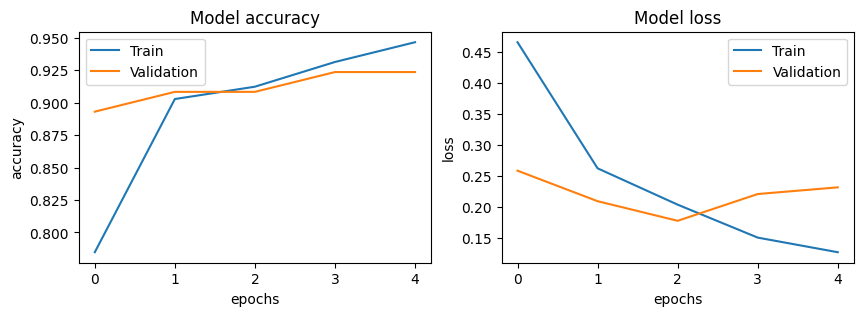

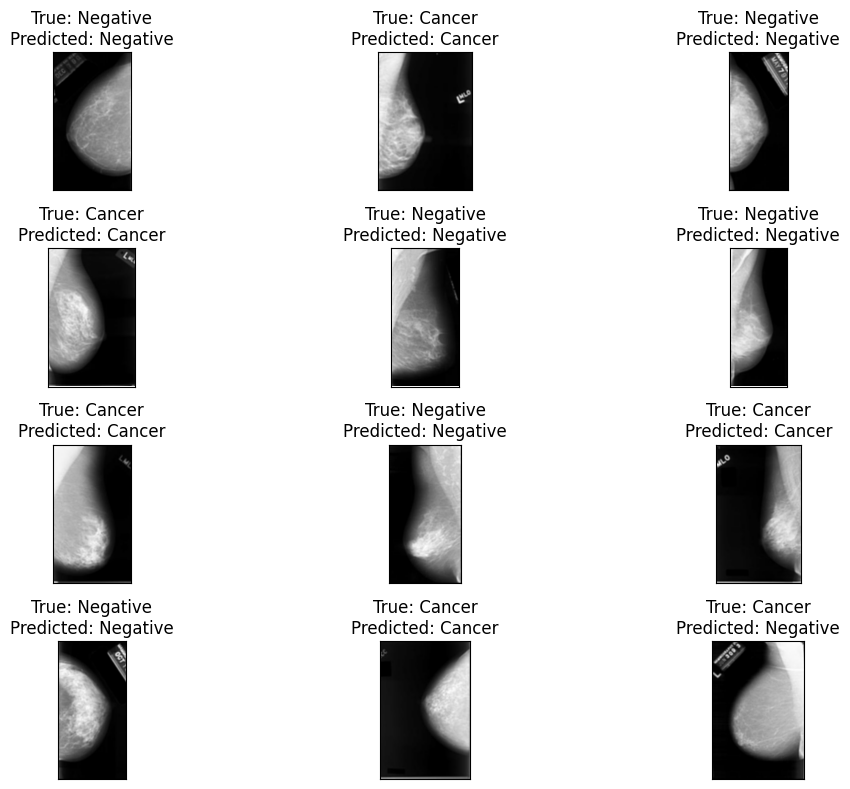

    Test Loss: 0.21742
Test Accuracy: 90.24%


In [50]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
ENet_pre=preprocess_input
train_gen_ENet, valid_gen_ENet, test_gen_ENet = gen(ENet_pre,train_df,test_df)
ENet_model, callback=func(EfficientNetB7)
start = time.time()
history = ENet_model.fit(
    train_gen_ENet,
    validation_data=valid_gen_ENet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
end = time.time()
print("Temps d'entrainement =",(format(((end-start)/60)/60),"heures"))
history_ENet=plot(history,test_gen_ENet,train_gen_ENet, ENet_model)

result_ENet = result_test(test_gen_ENet,ENet_model)

In [51]:
# Enregsitrement et chargement du modèle sous format .h5
 
# Enregistrement du modèle
ENet_model.save('./modeles/CNN_ref/EfficientNetB7_breast_cancer_120_120.h5')
print('ENet_model enregistré!')
 
# Chargement du modèle
savedModel=load_model('./modeles/CNN_ref/EfficientNetB7_breast_cancer_120_120.h5')
savedModel.summary()

ENet_model enregistré!
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 120, 120, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 120, 120, 3)          7         ['rescaling[0][0]']           
 tion)                                                                                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 120, 120, 3)          0         [

### ✔️ 5.3.2 ResNet

Found 525 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 164 validated image filenames belonging to 2 classes.
Temps d'entrainement = ('0.01025983260737525', 'heures')
6/6 [==============================] - 3s 393ms/step
              precision    recall  f1-score   support

      Cancer       0.91      0.98      0.94        82
    Negative       0.97      0.90      0.94        82

    accuracy                           0.94       164
   macro avg       0.94      0.94      0.94       164
weighted avg       0.94      0.94      0.94       164



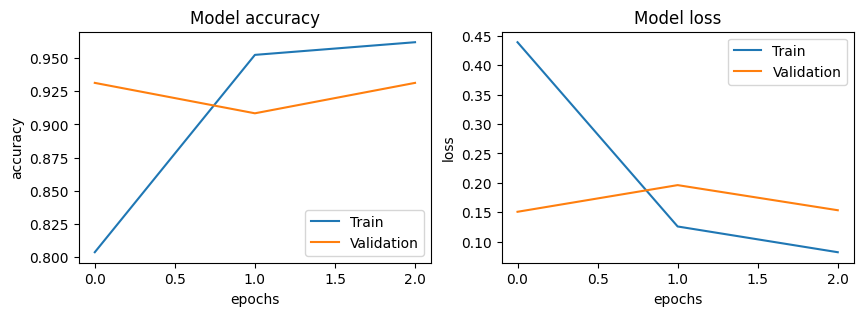

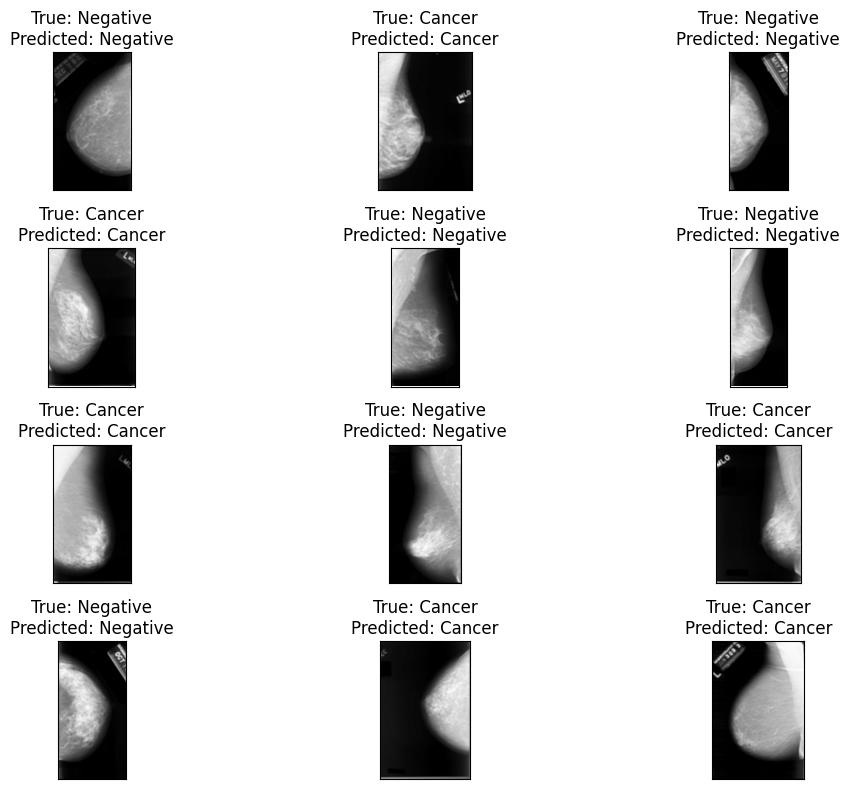

    Test Loss: 0.15198
Test Accuracy: 93.90%


In [52]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet_pre=preprocess_input
train_gen_ResNet, valid_gen_ResNet, test_gen_ResNet = gen(ResNet_pre,train_df,test_df)
ResNet_model, callback=func(ResNet50)
start = time.time()
history = ResNet_model.fit(
    train_gen_ResNet,
    validation_data=valid_gen_ResNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
end = time.time()
print("Temps d'entrainement =",(format(((end-start)/60)/60),"heures"))
history_ResNet= plot(history,test_gen_ResNet,train_gen_ResNet, ResNet_model)

result_ResNet = result_test(test_gen_ResNet,ResNet_model)

In [53]:
# Enregsitrement et chargement du modèle sous format .h5
 
# Enregistrement du modèle
ResNet_model.save('./modeles/CNN_ref/ResNet_model_breast_cancer_120_120.h5')
print('ResNet_model enregistré!')
 
# Chargement du modèle
savedModel=load_model('./modeles/CNN_ref/ResNet_model_breast_cancer_120_120.h5')
savedModel.summary()

ResNet_model enregistré!
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 126, 126, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 60, 60, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 60, 60, 64)           256       ['conv1_conv[0][0]']          
 on)                                                               

### ✔️ 5.3.3 MobileNet

Found 525 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 164 validated image filenames belonging to 2 classes.
Temps d'entrainement = ('0.003501391543282403', 'heures')
6/6 [==============================] - 1s 93ms/step
              precision    recall  f1-score   support

      Cancer       0.87      0.95      0.91        82
    Negative       0.95      0.85      0.90        82

    accuracy                           0.90       164
   macro avg       0.91      0.90      0.90       164
weighted avg       0.91      0.90      0.90       164



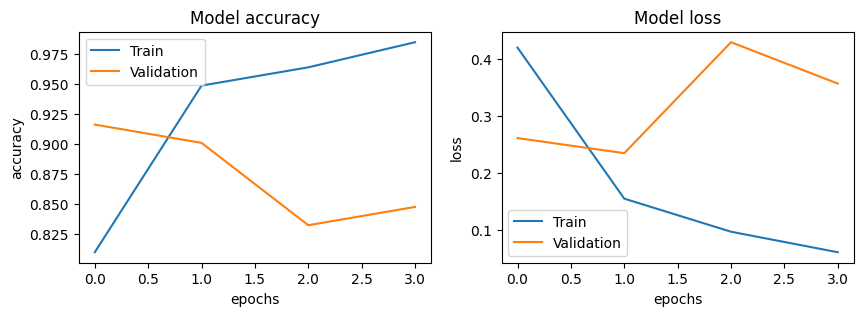

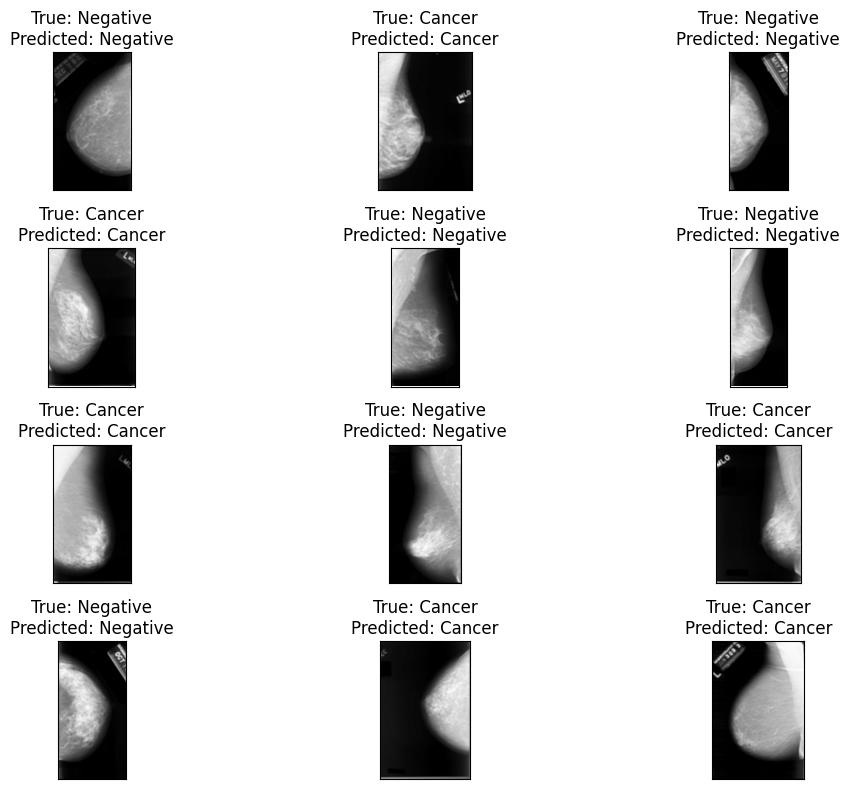

    Test Loss: 0.24314
Test Accuracy: 90.24%


In [54]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model, callback=func(MobileNet)
start = time.time()
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
end = time.time()
print("Temps d'entrainement =",(format(((end-start)/60)/60),"heures"))
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

In [55]:
# Enregsitrement et chargement du modèle sous format .h5
 
# Enregistrement du modèle
MobileNet_model.save('./modeles/CNN_ref/MobileNet_model_breast_cancer_120_120.h5')
print('MobileNet_model enregistré!')
 
# Chargement du modèle
savedModel=load_model('./modeles/CNN_ref/MobileNet_model_breast_cancer_120_120.h5')
savedModel.summary()

MobileNet_model enregistré!
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 60, 60, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 60, 60, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 60, 60, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 60, 60, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (N

### ✔️ 5.3.4 VGG19

Found 525 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 164 validated image filenames belonging to 2 classes.
Temps d'entrainement = ('0.03519513540797763', 'heures')
6/6 [==============================] - 7s 1s/step
              precision    recall  f1-score   support

      Cancer       0.90      0.90      0.90        82
    Negative       0.90      0.90      0.90        82

    accuracy                           0.90       164
   macro avg       0.90      0.90      0.90       164
weighted avg       0.90      0.90      0.90       164



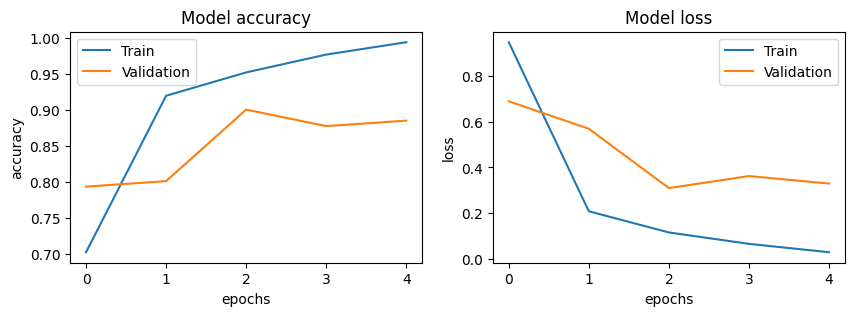

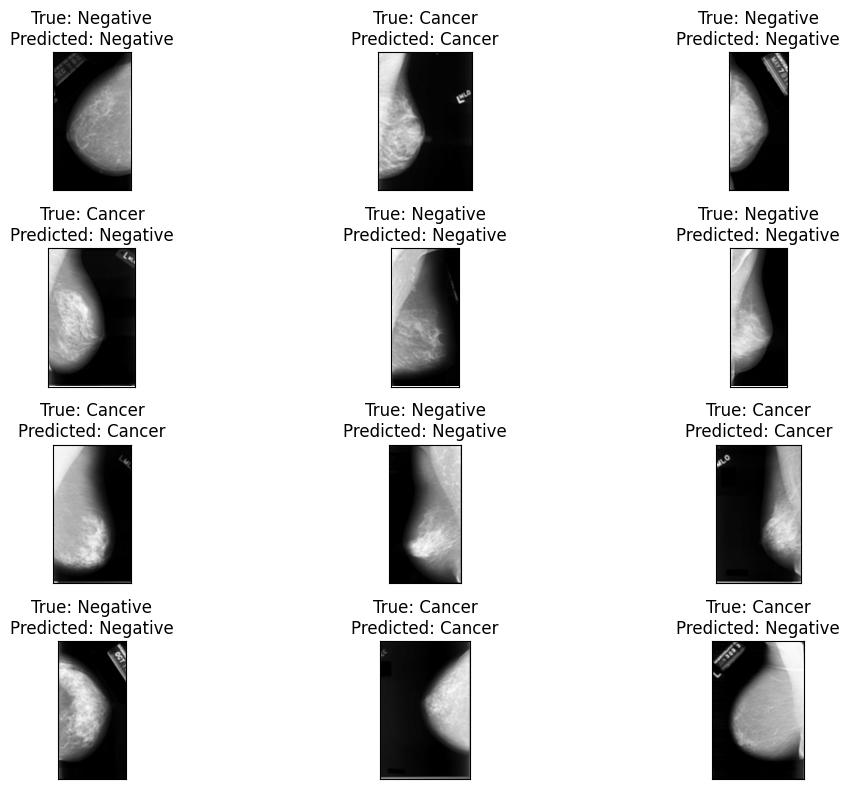

    Test Loss: 0.26084
Test Accuracy: 90.24%


In [56]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
VGG19_pre=preprocess_input
train_gen_VGG19, valid_gen_VGG19, test_gen_VGG19 = gen(VGG19_pre,train_df,test_df)
VGG19_model, callback=func(VGG19)
start = time.time()
history = VGG19_model.fit(
    train_gen_VGG19,
    validation_data=valid_gen_VGG19,
    epochs=100,
    callbacks=callback,
    verbose=0
)
end = time.time()
print("Temps d'entrainement =",(format(((end-start)/60)/60),"heures"))
history_VGG19= plot(history,test_gen_VGG19,train_gen_VGG19, VGG19_model)

result_VGG19 = result_test(test_gen_VGG19,VGG19_model)

In [57]:
# Enregsitrement et chargement du modèle sous format .h5
 
# Enregistrement du modèle
VGG19_model.save('./modeles/CNN_ref/VGG19_model_breast_cancer_120_120.h5')
print('VGG19_model enregistré!')
 
# Chargement du modèle
savedModel=load_model('./modeles/CNN_ref/VGG19_model_breast_cancer_120_120.h5')
savedModel.summary()

VGG19_model enregistré!
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None,

### ✔️ 5.3.5 Xception

Found 525 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 164 validated image filenames belonging to 2 classes.
Temps d'entrainement = ('0.012512397368748982', 'heures')
6/6 [==============================] - 3s 388ms/step
              precision    recall  f1-score   support

      Cancer       0.94      0.91      0.93        82
    Negative       0.92      0.94      0.93        82

    accuracy                           0.93       164
   macro avg       0.93      0.93      0.93       164
weighted avg       0.93      0.93      0.93       164



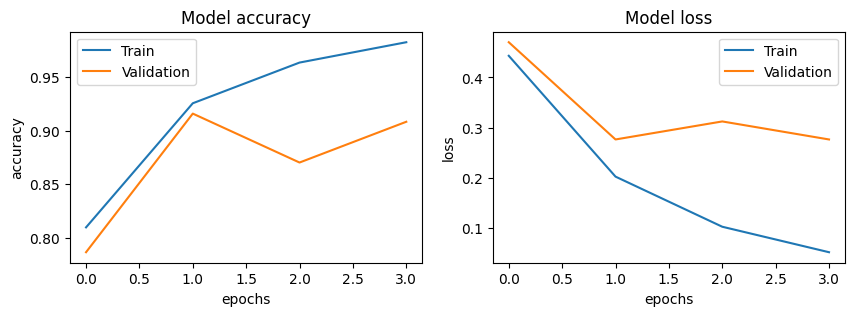

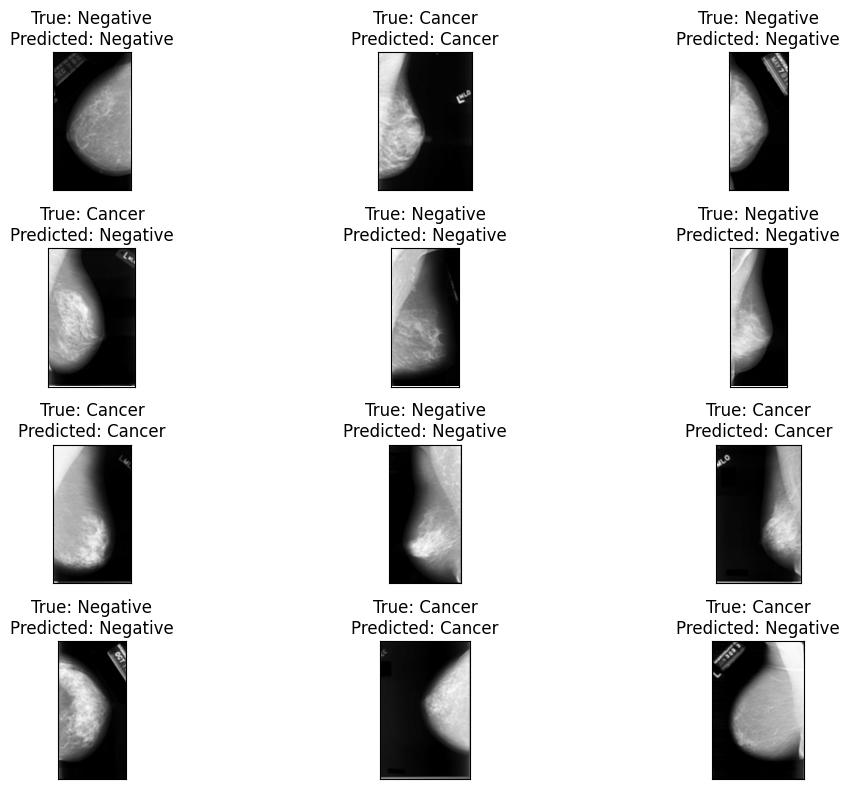

    Test Loss: 0.20930
Test Accuracy: 92.68%


In [58]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)
Xception_model, callback=func(Xception)
start = time.time()
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=100,
    callbacks=callback,
    verbose=0
)
end = time.time()
print("Temps d'entrainement =",(format(((end-start)/60)/60),"heures"))
history_Xception = plot(history,test_gen_Xception,train_gen_Xception, Xception_model)
result_Xception = result_tresult_Xception = result_test(test_gen_Xception,Xception_model)

In [59]:
# Enregsitrement et chargement du modèle sous format .h5
 
# Enregistrement du modèle
Xception_model.save('./modeles/CNN_ref/Xception_model_breast_cancer_120_120.h5')
print('Xception_model enregistré!')
 
# Chargement du modèle
savedModel=load_model('./modeles/CNN_ref/Xception_model_breast_cancer_120_120.h5')
savedModel.summary()

Xception_model enregistré!
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 59, 59, 32)           864       ['input_6[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 59, 59, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 59, 59, 32)           0      

### ✔️ 5.3.6 InceptionResNetV2

Found 525 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 164 validated image filenames belonging to 2 classes.
Temps d'entrainement = ('0.01700761980480618', 'heures')
6/6 [==============================] - 5s 364ms/step
              precision    recall  f1-score   support

      Cancer       0.77      0.85      0.81        82
    Negative       0.84      0.74      0.79        82

    accuracy                           0.80       164
   macro avg       0.80      0.80      0.80       164
weighted avg       0.80      0.80      0.80       164



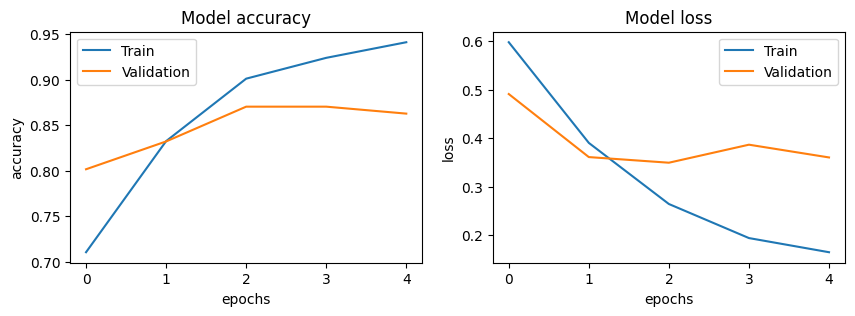

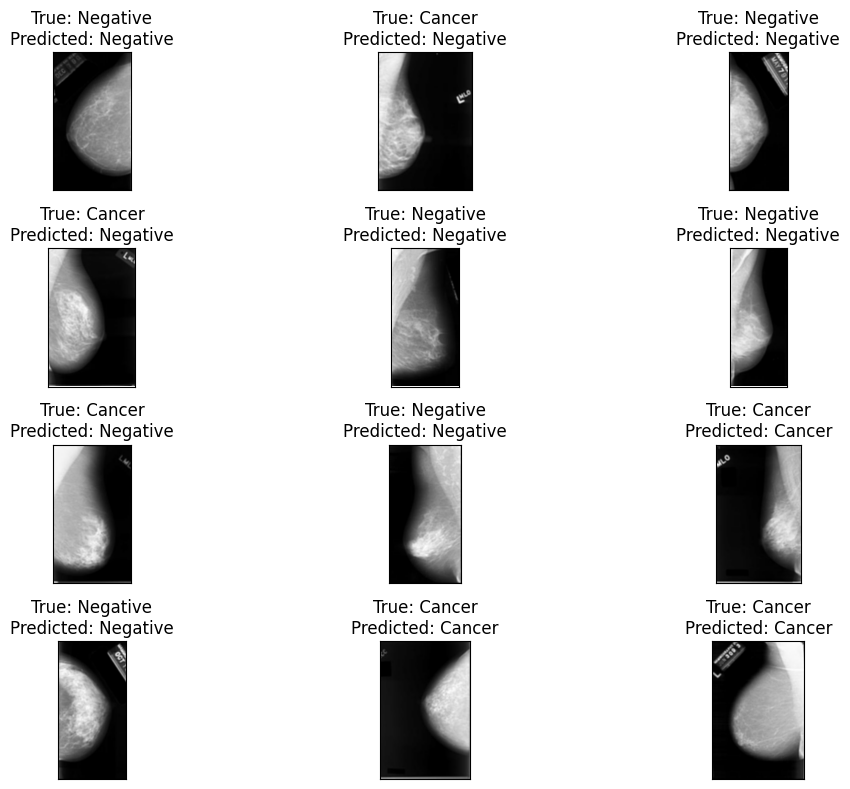

    Test Loss: 0.44520
Test Accuracy: 79.88%


In [60]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
IRNV2_pre=preprocess_input
train_gen_IRNV2, valid_gen_IRNV2, test_gen_IRNV2 = gen(IRNV2_pre,train_df,test_df)
IRNV2_model, callback=func(InceptionResNetV2)
start = time.time()
history = IRNV2_model.fit(
    train_gen_IRNV2,
    validation_data=valid_gen_IRNV2,
    epochs=100,
    callbacks=callback,
    verbose=0
)
end = time.time()
print("Temps d'entrainement =",(format(((end-start)/60)/60),"heures"))
history_IRNV2 =plot(history,test_gen_IRNV2,train_gen_IRNV2, IRNV2_model)
result_IRNV2 = result_tresult_IRNV2 = result_test(test_gen_IRNV2,IRNV2_model)

In [61]:
# Enregsitrement et chargement du modèle sous format .h5
 
# Enregistrement du modèle
IRNV2_model.save('./modeles/CNN_ref/IRNV2_model_breast_cancer_120_120.h5')
print('IRNV2_model enregistré!')
 
# Chargement du modèle
savedModel=load_model('./modeles/CNN_ref/IRNV2_model_breast_cancer_120_120.h5')
savedModel.summary()

IRNV2_model enregistré!
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 59, 59, 32)           864       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 59, 59, 32)           96        ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 59, 59, 32)           0         

### ✔️ 5.3.7 VGG16

Found 525 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 164 validated image filenames belonging to 2 classes.
Temps d'entrainement = ('0.0404440086417728', 'heures')
6/6 [==============================] - 5s 846ms/step
              precision    recall  f1-score   support

      Cancer       0.89      0.93      0.91        82
    Negative       0.92      0.89      0.91        82

    accuracy                           0.91       164
   macro avg       0.91      0.91      0.91       164
weighted avg       0.91      0.91      0.91       164



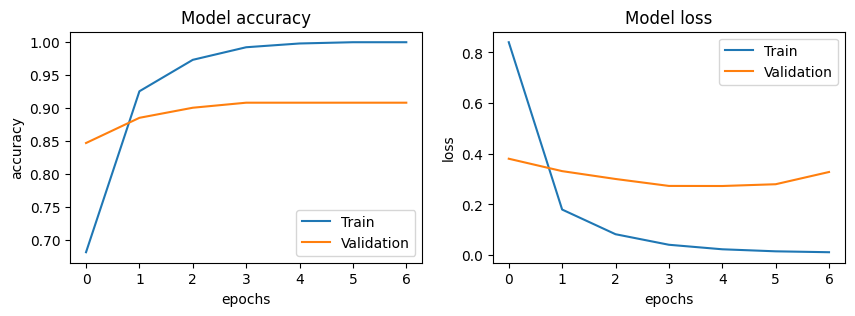

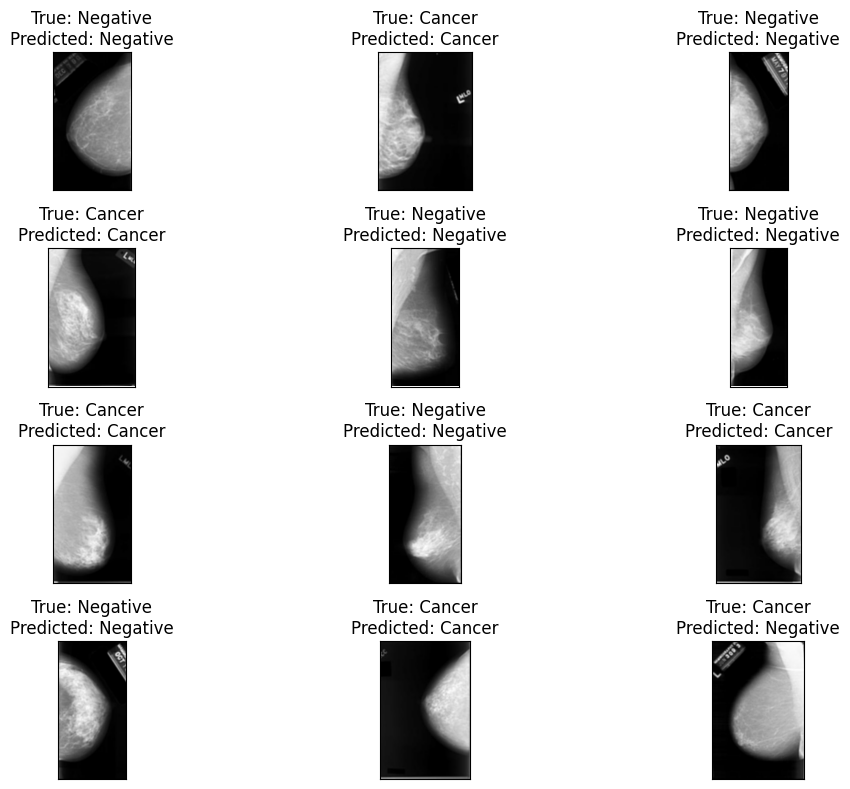

    Test Loss: 0.25977
Test Accuracy: 90.85%


In [62]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)
model_VGG16, callback=func(VGG16)
start = time.time()
history = model_VGG16.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback,
    verbose=0
)
end = time.time()
print("Temps d'entrainement =",(format(((end-start)/60)/60),"heures"))
history=plot(history,test_gen_VGG,train_gen_VGG, model_VGG16)
result_VGG16 = result_test(test_gen_VGG,model_VGG16)

In [63]:
# Enregsitrement et chargement du modèle sous format .h5
 
# Enregistrement du modèle
model_VGG16.save('./modeles/CNN_ref/model_VGG16_breast_cancer_120_120.h5')
print('model_VGG16 enregistré!')
 
# Chargement du modèle
savedModel=load_model('./modeles/CNN_ref/model_VGG16_breast_cancer_120_120.h5')
savedModel.summary()

model_VGG16 enregistré!
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None,

### ✔️ 5.3.8 ResNet101

Found 525 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 164 validated image filenames belonging to 2 classes.
Temps d'entrainement = ('0.01958864152431488', 'heures')
6/6 [==============================] - 9s 892ms/step
              precision    recall  f1-score   support

      Cancer       0.96      0.89      0.92        82
    Negative       0.90      0.96      0.93        82

    accuracy                           0.93       164
   macro avg       0.93      0.93      0.93       164
weighted avg       0.93      0.93      0.93       164



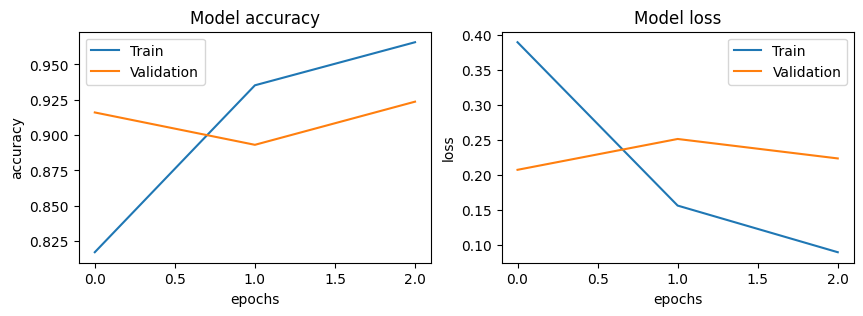

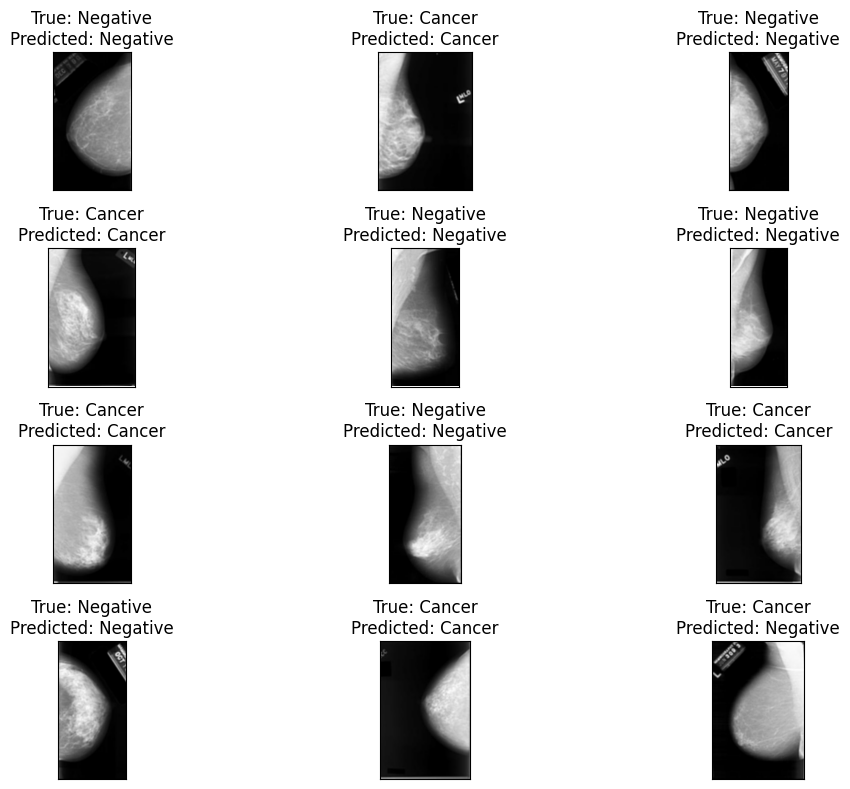

    Test Loss: 0.16732
Test Accuracy: 92.68%


In [64]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

ResNet101_pre=preprocess_input
train_gen_ResNet101, valid_gen_ResNet101, test_gen_ResNet101 = gen(ResNet101_pre,train_df,test_df)
model_ResNet101, callback=func(ResNet101)
start = time.time()
history = model_ResNet101.fit(
    train_gen_ResNet101,
    validation_data=valid_gen_ResNet101,
    epochs=100,
    callbacks=callback,
    verbose=0
)
end = time.time()
print("Temps d'entrainement =",(format(((end-start)/60)/60),"heures"))
history=plot(history,test_gen_ResNet101,train_gen_ResNet101, model_ResNet101)
result_ResNet101 = result_test(test_gen_ResNet101,model_ResNet101)

In [65]:
# Enregsitrement et chargement du modèle sous format .h5
 
# Enregistrement du modèle
model_ResNet101.save('./modeles/CNN_ref/model_ResNet101_breast_cancer_120_120.h5')
print('model_ResNet101 enregistré!')
 
# Chargement du modèle
savedModel=load_model('./modeles/CNN_ref/model_ResNet101_breast_cancer_120_120.h5')
savedModel.summary()

model_ResNet101 enregistré!
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 126, 126, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 60, 60, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 60, 60, 64)           256       ['conv1_conv[0][0]']          
 on)                                                            

### ✔️ 5.3.9 DenseNet201

Found 525 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 164 validated image filenames belonging to 2 classes.
Temps d'entrainement = ('0.04685546398162842', 'heures')
6/6 [==============================] - 7s 592ms/step
              precision    recall  f1-score   support

      Cancer       0.92      0.96      0.94        82
    Negative       0.96      0.91      0.94        82

    accuracy                           0.94       164
   macro avg       0.94      0.94      0.94       164
weighted avg       0.94      0.94      0.94       164



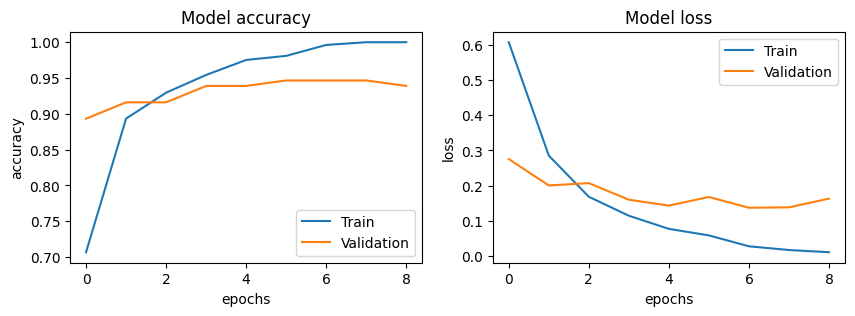

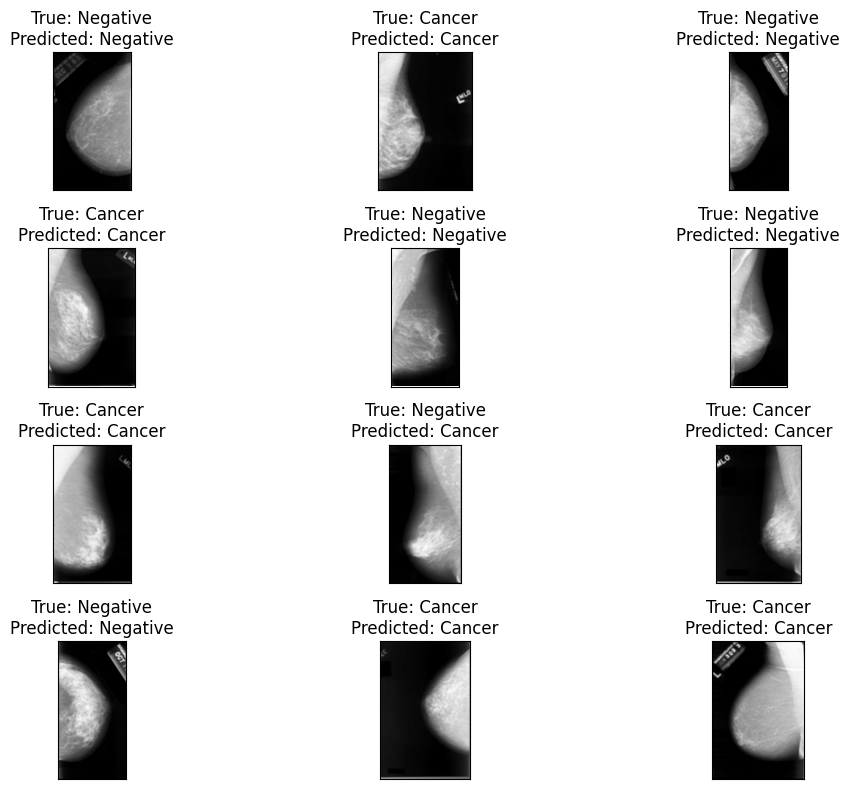

    Test Loss: 0.22673
Test Accuracy: 93.90%


In [66]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet201_pre=preprocess_input
train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = gen(DenseNet201_pre,train_df,test_df)
model_DenseNet201, callback=func(DenseNet201)
start = time.time()
history = model_DenseNet201.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=100,
    callbacks=callback,
    verbose=0
)
end = time.time()
print("Temps d'entrainement =",(format(((end-start)/60)/60),"heures"))
history=plot(history,test_gen_DenseNet201,train_gen_DenseNet201, model_DenseNet201)
result_DenseNet201 = result_test(test_gen_DenseNet201,model_DenseNet201)

In [67]:
# Enregsitrement et chargement du modèle sous format .h5
 
# Enregistrement du modèle
model_DenseNet201.save('./modeles/CNN_ref/model_DenseNet201_breast_cancer_120_120.h5')
print('model_DenseNet201 enregistré!')
 
# Chargement du modèle
savedModel=load_model('./modeles/CNN_ref/model_DenseNet201_breast_cancer_120_120.h5')
savedModel.summary()

model_DenseNet201 enregistré!
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 126, 126, 3)          0         ['input_10[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 60, 60, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 60, 60, 64)           256 

### 📊 5.3.10  Bilan des performances des CNNs de références

In [68]:
output = pd.DataFrame({'Model':['EfficientNetB7','ResNet50','MobileNet','VGG19','Xception','InceptionResNetV2',
                               'VGG16','ResNet101','DenseNet201'],
                      'Accuracy':[result_ENet[1], result_ResNet[1], result_MobileNet[1], result_VGG19[1],
                                  result_Xception[1],result_IRNV2[1],result_VGG16[1],result_ResNet101[1],
                                 result_DenseNet201[1]]})

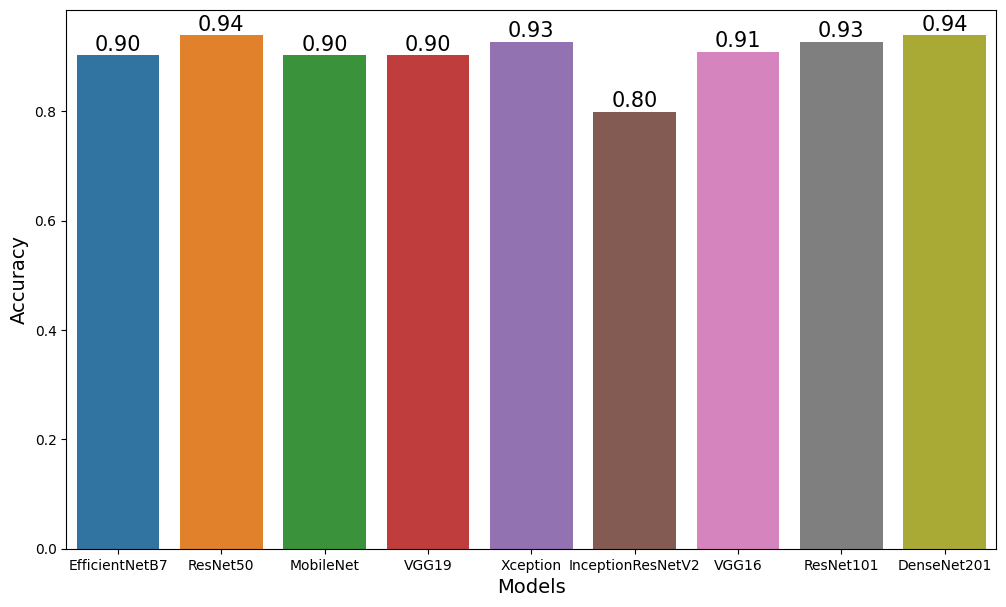

In [69]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()

## 🦾 5.4 Prédictions par le meilleur modèle

In [70]:
#Chargement du modèle
bestModel=load_model('./modeles/breast_cancer_vit.h5', custom_objects={'Patches': Patches,'PatchEncoder': PatchEncoder})
results = bestModel.evaluate(x_test, y_test)
print('Le modèle atteint un niveau de précision de {}%!'.format(round(results[1]*100,2)))

6/6 [==============================] - 2s 81ms/step - loss: 0.1054 - accuracy: 0.9817 - top-5-accuracy: 1.0000
Le modèle atteint un niveau de précision de 98.17%!


In [71]:
def fct_prediction(x_test, y_test, model):
    
    j=randint(0,len(y_test)-1)
    img = np.expand_dims(x_test[j], axis=0)
    #j=762
    if y_test[j]==0:
        print("L'image suivante ne montre pas de pathologie de cancer :")
    else :
        print("L'image suivante montre une pathologie de cancer")
        
    plt.figure(figsize= (3,3))
    plt.imshow(x_test[j])
    
    
    prediction=model.predict(img)
    pred=np.argmax(prediction)
    if pred==1:
        print("Le modèle ViT prédit une pathologie de cancer sur cette image")
    else :
        print("Le modèle ViT ne prédit pas une pathologie de cancer image")
    
    if pred==y_test[j]:
        print("Prédiction OK")
    else :
        print("Prédiction NOK")

L'image suivante ne montre pas de pathologie de cancer :
1/1 [==============================] - 0s 28ms/step
Le modèle ViT ne prédit pas une pathologie de cancer image
Prédiction OK


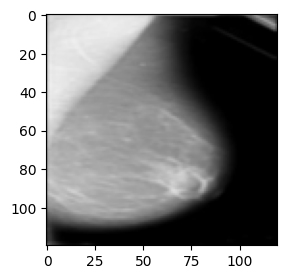

In [74]:
fct_prediction(x_test, y_test, bestModel)

# FIN 🦊 